# Fashion MNIST: Loading & Preprocessing Data

In [1]:
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.models as models
from torchvision.models import alexnet, AlexNet_Weights,mobilenet_v3_small,MobileNet_V3_Small_Weights, inception_v3, Inception_V3_Weights, vgg11, VGG11_Weights, resnet18,ResNet18_Weights
from torchvision.transforms import v2
import torch.optim as optim
from torch.optim import lr_scheduler
import os
from tempfile import TemporaryDirectory

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class TensorBoardLogger:
    def __init__(self, log_dir):
        self.summary_writer = SummaryWriter(log_dir)

    def add_scalars(self, tag_step_value_dict):
        """
        :param parent_tag: str, e.g. "Training Loss"
        :param tag_step_value_dict: dict, e.g., {"key":(step, value), "q_grad":(10000, 1.11)}
        """
        for tag, (step, value) in tag_step_value_dict.items():
            self.summary_writer.add_scalar(tag, value, step)

In [3]:
%load_ext tensorboard

## Train, Validation, Test datasets

In [3]:
import torch.utils
import torch.utils.data


train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))

seed = torch.Generator().manual_seed(42)
train_portion = 0.9
test_portion = 0.1

print(len(train_set))

train_set, valid_set = torch.utils.data.random_split(train_set,[train_portion,test_portion], seed)



test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))

60000


In [7]:
#Create Dataset Class
class FashionMNISTDataset(Dataset):
    def __init__(self,data) -> None:
        super().__init__() 

        #construct attributes for the features and labels in the dataset
        x = []
        y = []

        for i in range(len(data)):
            x.append(data[i][0])
            y.append(data[i][1])

        

        self.x = torch.stack(x)
        self.y = torch.Tensor(y)
        self.y = self.y.type(dtype=torch.LongTensor)

    def __getitem__(self, index):
        image = self.x[index]
        label = self.y[index]

        return image, label

    def __len__(self):
        return len(self.x)

In [8]:
train_dataset = FashionMNISTDataset(train_set)
valid_dataset = FashionMNISTDataset(valid_set)
test_dataset = FashionMNISTDataset(test_set)

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=100)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=100)

dataloaders = {"train" : [train_loader,len(train_dataset)],
               "valid" : [valid_loader,len(valid_dataset)],
               "test" : [test_loader,len(test_loader)]

}

In [10]:
train_dataset[0]

torch.Size([1, 28, 28])

In [11]:
fashion_mnist_labels = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }

In [12]:
labels_size = len(fashion_mnist_labels.keys())

In [13]:
def imshow(inp, normalized_image : str = False, title=None):
    """Display image for Tensor."""
    #inp = inp.numpy().transpose((-1,1, 2, 0))
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    if not normalized_image:
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

torch.Size([10, 1, 28, 28])
torch.Size([3, 62, 242])
['Ankle Boot', 'Pullover', 'Sandal', 'T-shirt/Top', 'Sandal', 'Trouser', 'Dress', 'Sandal', 'T-shirt/Top', 'Trouser']


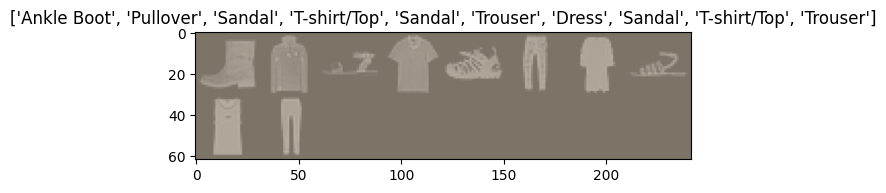

In [10]:
# Get a batch of training data

demo_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=10)
batch = next(iter(demo_loader))
images, labels = batch

print(images.shape)
# Make a grid from batch
out = torchvision.utils.make_grid(images)
print(out.shape)

title = [fashion_mnist_labels[int(x)] for x in labels]
print(title)
imshow(out, title=title)

In [11]:
dataloaders["valid"][1]

6000

In [14]:
def model_params_mode(model,mode : str):
    """
    This functino freezes/unfreezes model parameters depending on the desired input
    """
    if mode == "freeze":
        grad = False
    else:
        grad = True

    for param in model.parameters():
            param.requires_grad = grad



In [16]:
def update_model(model,out_dim : int, model_name : str):
    """
    This function modifies the model architecture to be compatible with the fashion MNIST output layer
    """

    

    if model_name == "AlexNet":
        in_features = model.classifier[1].in_features

        model.classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(in_features,out_dim),
        nn.Softmax(dim=-1)
    )


    elif model_name == "VGG":
        in_features =  model.classifier[0].in_features


        model.classifier = nn.Sequential(
            nn.Linear(in_features,out_dim),
            nn.Softmax(dim=-1)
        )

    elif model_name == "MobileNet":
        in_features = model.classifier[3].in_features

        model.classifier[3] = nn.Sequential(
            nn.Linear(in_features,out_dim),
            nn.Softmax(dim=-1)
        )

    elif model_name == "InceptionV3":
        in_features = model.fc.in_features

        model.fc = nn.Sequential(
            nn.Linear(in_features,out_dim),
            nn.Softmax(dim=-1)
        )
    

    return model



In [14]:
class Model(nn.Module):
    def __init__(self, base_model,neurons : list,base_model_name : str = None) -> None:
        super().__init__()
        self.base_model = base_model
        self.base_model_name = base_model_name
        self.neurons = neurons
        self.replaceOutputLayer()
        

    def replaceOutputLayer(self):
        for param in self.base_model.parameters():
            param.requires_grad = False

        last_layer = None
        if self.base_model_name == "AlexNet": 

            old_out_features = self.base_model.classifier[6].out_features
            #self.base_model.classifier = nn.Linear(old_in_features,self.neurons[1])
            
        self.out_layer_1 = nn.Linear(old_out_features,self.neurons[1])



    def forward(self,x):
        x = self.base_model(x)
        return self.out_layer_1(x)



In [17]:
transform_im = v2.Compose([
    v2.Resize(size=(299,299)),
    #v2.RandomResizedCrop(size=(299, 299), antialias=True),
    #v2.RandomHorizontalFlip(p=0.5),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10, 1, 28, 28])
torch.Size([10, 3, 299, 299])
torch.Size([3, 604, 2410])


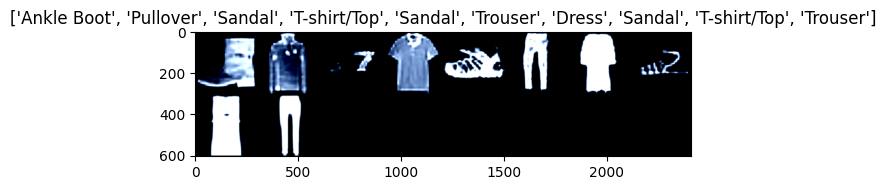

In [19]:
demo_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=10)
batch = next(iter(demo_loader))
images, labels = batch
print(images.shape)
images = transform_im(images)
print(images.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(images)
print(out.shape)

title = [fashion_mnist_labels[int(x)] for x in labels]

imshow(out,True, title=title)

In [20]:
def train_model(model, criterion, optimizer,dataloaders,weight_dir,logger : TensorBoardLogger,scheduler = None, num_epochs=25,debug = False):
        since = time.time()

   
        os.makedirs(weight_dir, exist_ok=True)
        best_model_params_path = os.path.join(weight_dir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        log_vars = {}
        

        for epoch in range(num_epochs):

            log_vars.update({
                "learning_rate" : (epoch,scheduler.get_last_lr()[0] if scheduler else optimizer.param_groups[0]['lr'])
            }
            )


            if debug:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'valid']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase][0]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(transform_im(inputs))

                        outputs = outputs[0] if isinstance(outputs, torchvision.models.inception.InceptionOutputs) else outputs
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                if phase == 'train' and scheduler:
                    scheduler.step()

                epoch_loss = running_loss / dataloaders[phase][1]
                epoch_acc = running_corrects.double() / dataloaders[phase][1]

                if debug:
                    print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}\n')

                # deep copy the model
                if phase == 'valid' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

                log_vars.update(
                    {f"{phase}/Loss" : (epoch,epoch_loss),
                                      f"{phase}/Accuracy" : (epoch,epoch_acc.cpu().numpy())
                    }
                )
                
                logger.add_scalars(log_vars)
        

        time_elapsed = time.time() - since
        if debug:
            print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
            print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
        return model

In [18]:
def test_model(model,logger : TensorBoardLogger):
    model.eval()

    log_vars = {}

    tot_accurate_pred = 0


    for i,(image,labels) in enumerate(dataloaders["test"][0]):
        image,labels = image.to(device),labels.to(device)

        #predictions...
        with torch.no_grad():
            predictions = model(transform_im(image))
            _,predictions = torch.max(predictions,dim=-1)
            accurate_pred = torch.sum(predictions == labels.data)


        log_vars.update(
            {
                "Test/Accuracy_Batch" : (i, accurate_pred.double().cpu().numpy() / image.shape[0])
            }
        )

        logger.add_scalars(log_vars)

        tot_accurate_pred += accurate_pred.double().cpu().numpy()

    logger.add_scalars(
            {
                "Test/Accuracy_Tot" : (0, tot_accurate_pred / dataloaders["test"][1])
            }
        )
    

    





# AlexNet for Image Classification : Fashion MNIST

In [21]:
alexnet_model = alexnet(AlexNet_Weights.DEFAULT)

c:\Users\kevin\miniconda3\envs\neural_sys_fashion_mnist\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [22]:
alexnet_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [23]:
model_params_mode(alexnet_model,"freeze")
alexnet_model = update_model(alexnet_model,labels_size,"AlexNet")

In [24]:
alexnet_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=10, bias=True)
   

In [23]:
demo_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=10)
batch = next(iter(demo_loader))
images, labels = batch
inputs = transform_im(images)
with torch.no_grad():
    inputs,labels = inputs.to(device), labels.to(device)
    alexnet_model.to(device)
    alexnet_model.eval()
    outputs = alexnet_model(inputs)
outputs

tensor([[0.1163, 0.0628, 0.1242, 0.1029, 0.0649, 0.1138, 0.0786, 0.1592, 0.0943,
         0.0830],
        [0.0915, 0.0642, 0.1396, 0.1226, 0.0942, 0.1493, 0.0719, 0.1222, 0.0876,
         0.0569],
        [0.1092, 0.0975, 0.1229, 0.1073, 0.0964, 0.1152, 0.0904, 0.0940, 0.0920,
         0.0752],
        [0.0731, 0.0940, 0.1504, 0.0979, 0.1120, 0.1246, 0.0605, 0.0968, 0.1305,
         0.0602],
        [0.1345, 0.0813, 0.1135, 0.0990, 0.0717, 0.1215, 0.0435, 0.0998, 0.1386,
         0.0965],
        [0.0920, 0.0556, 0.1147, 0.1343, 0.0811, 0.2155, 0.0642, 0.0996, 0.0936,
         0.0495],
        [0.0503, 0.0906, 0.1836, 0.1178, 0.0695, 0.1260, 0.0695, 0.0909, 0.1371,
         0.0646],
        [0.1673, 0.1098, 0.1031, 0.0976, 0.0803, 0.1122, 0.0489, 0.1231, 0.0824,
         0.0753],
        [0.0783, 0.0633, 0.1505, 0.0979, 0.1166, 0.1680, 0.0882, 0.0829, 0.0981,
         0.0562],
        [0.0840, 0.0510, 0.1255, 0.1296, 0.0805, 0.1913, 0.0665, 0.1009, 0.1052,
         0.0655]], device='c

## Training AlexNet for Image Classification : Fashion MNIST

In [24]:
alexnet_model= alexnet_model.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_alexnet = optim.Adam(alexnet_model.classifier.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs

exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_alexnet,0.8)
#lr_scheduler.StepLR(optimizer_alexnet, step_size=2, gamma=0.1)


In [25]:
dir = os.path.abspath(os.getcwd()) + "/model/AlexNet_FE/"
log_dir = os.path.abspath(os.getcwd()) + "/runs/AlexNet_FE/"
os.makedirs(log_dir, exist_ok=True)
logger = TensorBoardLogger(log_dir)

In [ ]:
alexnet_model = train_model(alexnet_model, criterion, optimizer_alexnet,
                         dataloaders,dir,logger, num_epochs=30,debug=True)

In [ ]:
#Test in AlexNet FeatureExtractor
#log_dir = os.path.abspath(os.getcwd()) + "/runs/AlexNet_FeatureExtractor_Test/"
#os.makedirs(log_dir, exist_ok=True)
#logger = TensorBoardLogger(log_dir)
test_model(alexnet_model,logger)

In [25]:
%tensorboard --logdir runs/

UsageError: Line magic function `%tensorboard` not found.


## Fine-Tuning AlexNet for Image Classification : Fashion MNIST

In [ ]:
dir = os.path.abspath(os.getcwd()) + "/model/AlexNet_FineTune/"
log_dir = os.path.abspath(os.getcwd()) + "/runs/AlexNet_FineTune/"
os.makedirs(log_dir, exist_ok=True)
logger = TensorBoardLogger(log_dir)

In [ ]:
model_params_mode(alexnet_model, "unfreeze")

optimizer_alexnet = optim.Adam(alexnet_model.parameters(), lr=0.00001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_alexnet, step_size=1, gamma=0.00001)

alexnet_model = train_model(alexnet_model, criterion, optimizer_alexnet,
                         dataloaders,dir,logger, num_epochs=10,debug=True)

Epoch 0/9
----------
train Loss: 1.5337 Acc: 0.9316

valid Loss: 1.5471 Acc: 0.9148

Epoch 1/9
----------
train Loss: 1.5288 Acc: 0.9357

valid Loss: 1.5448 Acc: 0.9180

Epoch 2/9
----------
train Loss: 1.5248 Acc: 0.9400

valid Loss: 1.5439 Acc: 0.9178

Epoch 3/9
----------
train Loss: 1.5223 Acc: 0.9416

valid Loss: 1.5418 Acc: 0.9208

Epoch 4/9
----------
train Loss: 1.5205 Acc: 0.9432

valid Loss: 1.5413 Acc: 0.9205

Epoch 5/9
----------
train Loss: 1.5190 Acc: 0.9451

valid Loss: 1.5413 Acc: 0.9193

Epoch 6/9
----------
train Loss: 1.5168 Acc: 0.9470

valid Loss: 1.5410 Acc: 0.9218

Epoch 7/9
----------
train Loss: 1.5145 Acc: 0.9493

valid Loss: 1.5397 Acc: 0.9208

Epoch 8/9
----------
train Loss: 1.5138 Acc: 0.9503

valid Loss: 1.5392 Acc: 0.9225

Epoch 9/9
----------
train Loss: 1.5118 Acc: 0.9524

valid Loss: 1.5378 Acc: 0.9248

Training complete in 81m 36s
Best val Acc: 0.924833


## Test AlexNet

In [28]:
dir = os.path.abspath(os.getcwd()) + "/model/AlexNet_FineTune/"
log_dir = os.path.abspath(os.getcwd()) + "/runs/AlexNet_FineTune/"
logger = TensorBoardLogger(log_dir)

alexnet_model.load_state_dict(torch.load(dir + 'best_model_params.pt'))

<All keys matched successfully>

In [29]:
test_model(alexnet_model,logger)

# VGG16 for Image Classification : Fashion MNIST

In [30]:
vgg_model = vgg11(VGG11_Weights.DEFAULT)

c:\Users\kevin\miniconda3\envs\neural_sys_fashion_mnist\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [31]:
vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [32]:
model_params_mode(vgg_model,"freeze")
vgg_model = update_model(vgg_model,labels_size,"VGG")

## Training VGG16 for Image Classification : Fashion MNIST

In [35]:
vgg_model= vgg_model.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_vggnet = optim.Adam(vgg_model.classifier.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs

exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_vggnet,0.8)

In [ ]:
dir = os.path.abspath(os.getcwd()) + "/model/VGG_FE/"
log_dir = os.path.abspath(os.getcwd()) + "/runs/VGG_FE/"
os.makedirs(log_dir, exist_ok=True)
logger = TensorBoardLogger(log_dir)

In [ ]:
vgg_model = train_model(vgg_model, criterion, optimizer_vggnet,
                         dataloaders,dir,logger, num_epochs=30,debug=True)

Epoch 0/29
----------
train Loss: 1.6556 Acc: 0.8509

valid Loss: 1.5888 Acc: 0.8947

Epoch 1/29
----------
train Loss: 1.5704 Acc: 0.9108

valid Loss: 1.5686 Acc: 0.9078

Epoch 2/29
----------
train Loss: 1.5531 Acc: 0.9246

valid Loss: 1.5593 Acc: 0.9152

Epoch 3/29
----------
train Loss: 1.5428 Acc: 0.9333

valid Loss: 1.5536 Acc: 0.9190

Epoch 4/29
----------
train Loss: 1.5354 Acc: 0.9398

valid Loss: 1.5498 Acc: 0.9215

Epoch 5/29
----------
train Loss: 1.5297 Acc: 0.9452

valid Loss: 1.5470 Acc: 0.9232

Epoch 6/29
----------
train Loss: 1.5250 Acc: 0.9490

valid Loss: 1.5449 Acc: 0.9257

Epoch 7/29
----------
train Loss: 1.5209 Acc: 0.9524

valid Loss: 1.5433 Acc: 0.9272

Epoch 8/29
----------
train Loss: 1.5173 Acc: 0.9558

valid Loss: 1.5420 Acc: 0.9278

Epoch 9/29
----------
train Loss: 1.5142 Acc: 0.9586

valid Loss: 1.5410 Acc: 0.9285

Epoch 10/29
----------
train Loss: 1.5115 Acc: 0.9610

valid Loss: 1.5402 Acc: 0.9282

Epoch 11/29
----------
train Loss: 1.5090 Acc: 0.9631

## Fine-Tuning VGG16 for Image Classification : Fashion MNIST

In [ ]:
dir = os.path.abspath(os.getcwd()) + "/model/VGGNet_FineTune/"
log_dir = os.path.abspath(os.getcwd()) + "/runs/VGGNet_FineTune/"
os.makedirs(log_dir, exist_ok=True)
logger = TensorBoardLogger(log_dir)

In [ ]:
model_params_mode(vgg_model, "unfreeze")


optimizer_vgg = optim.Adam(vgg_model.parameters(), lr=0.00001)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_mobilenet_v3, step_size=1, gamma=0.1)

vgg_model = train_model(vgg_model, criterion, optimizer_vgg,
                         dataloaders,dir,logger, num_epochs=10,debug=True)

## test VGG16

In [36]:
dir = os.path.abspath(os.getcwd()) + "/model/VGG_FE/"
log_dir = os.path.abspath(os.getcwd()) + "/runs/VGG_FE/"
logger = TensorBoardLogger(log_dir)

vgg_model.load_state_dict(torch.load(dir + 'best_model_params.pt'))

<All keys matched successfully>

In [37]:
test_model(vgg_model,logger)

c:\Users\kevin\miniconda3\envs\neural_sys_fashion_mnist\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


# Inception V3 for Image Classification : Fashion MNIST

In [43]:
inception_v3_model = inception_v3(Inception_V3_Weights.DEFAULT)

c:\Users\kevin\miniconda3\envs\neural_sys_fashion_mnist\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [44]:
inception_v3_model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [45]:
model_params_mode(inception_v3_model,"freeze")
inception_v3_model = update_model(inception_v3_model,labels_size,"InceptionV3")

## Training Inception V3 for Image Classification : Fashion MNIST

In [46]:
inception_v3_model= inception_v3_model.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_inception_v3 = optim.Adam(inception_v3_model.fc.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs

exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_inception_v3,0.8)
#lr_scheduler.StepLR(optimizer_alexnet, step_size=2, gamma=0.1)

In [ ]:
dir = os.path.abspath(os.getcwd()) + "/model/InceptionV3_FE/"
log_dir = os.path.abspath(os.getcwd()) + "/runs/InceptionV3_FE/"
os.makedirs(log_dir, exist_ok=True)
logger = TensorBoardLogger(log_dir)

In [ ]:
inception_v3_model = train_model(inception_v3_model, criterion, optimizer_inception_v3,
                         dataloaders,dir,logger, num_epochs=30,debug=True)

## Test InceptionV3

In [ ]:
dir = os.path.abspath(os.getcwd()) + "/model/InceptionV3_FE/"
log_dir = os.path.abspath(os.getcwd()) + "/runs/InceptionV3_FE/"
logger = TensorBoardLogger(log_dir)

inception_v3_model.load_state_dict(torch.load(dir + 'best_model_params.pt'))

# MobileNet V3 for Image Classification : Fashion MNIST

In [54]:
mobilenet_v3_small_model = mobilenet_v3_small(MobileNet_V3_Small_Weights.DEFAULT)

In [55]:
mobilenet_v3_small_model.features[12:]

Sequential(
  (12): Conv2dNormActivation(
    (0): Conv2d(96, 576, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(576, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
)

In [56]:
mobilenet_v3_small_model.classifier

Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=1000, bias=True)
)

In [57]:
model_params_mode(mobilenet_v3_small_model,"freeze")
mobilenet_v3_small_model = update_model(mobilenet_v3_small_model,labels_size,"MobileNet")

In [ ]:
mobilenet_v3_small_model.classifier

Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Sequential(
    (0): Linear(in_features=1024, out_features=10, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Training MobileNet V3 for Image Classification : Fashion MNIST

In [58]:
mobilenet_v3_small_model= mobilenet_v3_small_model.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_mobilenet_v3 = optim.Adam(mobilenet_v3_small_model.classifier[3].parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs

exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_mobilenet_v3,0.8)
#lr_scheduler.StepLR(optimizer_alexnet, step_size=2, gamma=0.1)

In [ ]:
dir = os.path.abspath(os.getcwd()) + "/model/MobileNet_FE/"
log_dir = os.path.abspath(os.getcwd()) + "/runs/MobileNet_FE/"
os.makedirs(log_dir, exist_ok=True)
logger = TensorBoardLogger(log_dir)

In [ ]:
mobilenet_v3_small_model = train_model(mobilenet_v3_small_model, criterion, optimizer_mobilenet_v3,
                         dataloaders,dir,logger, num_epochs=30,debug=True)

Epoch 0/29
----------
train Loss: 2.0676 Acc: 0.6006

valid Loss: 1.9861 Acc: 0.7263

Epoch 1/29
----------
train Loss: 1.8265 Acc: 0.7660

valid Loss: 1.7812 Acc: 0.7765

Epoch 2/29
----------
train Loss: 1.7581 Acc: 0.7864

valid Loss: 1.7386 Acc: 0.7927

Epoch 3/29
----------
train Loss: 1.7262 Acc: 0.7993

valid Loss: 1.7143 Acc: 0.8027

Epoch 4/29
----------
train Loss: 1.7060 Acc: 0.8089

valid Loss: 1.6981 Acc: 0.8123

Epoch 5/29
----------
train Loss: 1.6922 Acc: 0.8161

valid Loss: 1.6863 Acc: 0.8178

Epoch 6/29
----------
train Loss: 1.6815 Acc: 0.8224

valid Loss: 1.6773 Acc: 0.8232

Epoch 7/29
----------
train Loss: 1.6730 Acc: 0.8281

valid Loss: 1.6701 Acc: 0.8272

Epoch 8/29
----------
train Loss: 1.6659 Acc: 0.8316

valid Loss: 1.6642 Acc: 0.8295

Epoch 9/29
----------
train Loss: 1.6606 Acc: 0.8350

valid Loss: 1.6591 Acc: 0.8330

Epoch 10/29
----------
train Loss: 1.6561 Acc: 0.8376

valid Loss: 1.6550 Acc: 0.8355

Epoch 11/29
----------
train Loss: 1.6523 Acc: 0.8399

## Fine-Tuning MobileNet V3 for Image Classification : Fashion MNIST

In [ ]:
dir = os.path.abspath(os.getcwd()) + "/model/MobileNet_FineTune/"
log_dir = os.path.abspath(os.getcwd()) + "/runs/MobileNet_FineTune/"
os.makedirs(log_dir, exist_ok=True)
logger = TensorBoardLogger(log_dir)

In [ ]:
model_params_mode(mobilenet_v3_small_model, "unfreeze")


optimizer_mobilenet_v3 = optim.Adam(mobilenet_v3_small_model.parameters(), lr=0.00001)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_mobilenet_v3, step_size=1, gamma=0.1)

mobilenet_v3_small_model = train_model(mobilenet_v3_small_model, criterion, optimizer_mobilenet_v3,
                         dataloaders,dir,logger, num_epochs=10,debug=True)

## Test MobileNet V3

In [59]:
dir = os.path.abspath(os.getcwd()) + "/model/MobileNet_FE/"
log_dir = os.path.abspath(os.getcwd()) + "/runs/MobileNet_FE/"
logger = TensorBoardLogger(log_dir)

mobilenet_v3_small_model.load_state_dict(torch.load(dir + 'best_model_params.pt'))

<All keys matched successfully>

In [60]:
test_model(mobilenet_v3_small_model,logger)